In [73]:
#Import necessary  libraries
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import librosa.display
import os
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

#glob used to return all file paths that match a specific pattern
from glob import glob

### Path for  audio files


In [2]:
def files(db,machine,type_machine):
    files = []
    for i in range(0,7,2):
        data_dir = f"Audio_Files/{db}dB_{machine}/id_0{i}/{type_machine}"
        files += glob(data_dir + '/*.wav')  
    return files


In [3]:
# 0_db_normal_fan

o_db_normal_fan = files(0,'fan','normal')

# 0_db_abnormal_fan

o_db_abnormal_fan = files(0,'fan','abnormal')

# 6_db_normal_fan

p6_db_normal_fan = files(6,'fan','normal')

# 6_db_abnormal_fan

p6_db_abnormal_fan = files(6,'fan','abnormal')

# -6_db_normal_fan

min6_db_normal_fan = files(-6,'fan','normal')

# -6_db_abnormal_fan

min6_db_abnormal_fan = files(-6,'fan','abnormal')


### Get all normal files

In [4]:
normal_fan = p6_db_normal_fan + o_db_normal_fan + min6_db_normal_fan

### Get all abnormal files

In [5]:
abnormal_fan = p6_db_abnormal_fan + o_db_abnormal_fan + min6_db_abnormal_fan

In [6]:
len(abnormal_fan)

4425

### Get .png 

In [104]:
def to_png(files,directory,name_file):    

    for i in range(len(files)):
        data, sr = librosa.load(files[i])
        data = scale(data)
       
        countstr = str(i)

        melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
           
        log_melspec = librosa.power_to_db(melspec, ref=np.max)  
        librosa.display.specshow(log_melspec, sr=sr)
            
        
      
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        png_number= name_file + countstr  


        plt.savefig(directory + '/' + (png_number) + '.png')            
    
    return 0

In [ ]:
# save normal fan to .png
to_png(normal_fan,'Normal','normal_')

In [ ]:
# save abnormal fan to .png
to_png(abnormal_fan,'Abnormal','abnormal_')

In [45]:
data, sr = librosa.load(normal_fan[1])

In [46]:
data

array([0.00675145, 0.00731525, 0.00562506, ..., 0.00300432, 0.00412645,
       0.00288242], dtype=float32)

In [47]:
data = scale(data)

In [48]:
data

array([1.4734191, 1.5965308, 1.2274562, ..., 0.6551872, 0.9002181,
       0.628569 ], dtype=float32)

In [49]:
melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)

In [50]:
type(melspec)

numpy.ndarray

In [51]:
melspec.shape

(128, 431)

### Data set path

In [6]:
size = (432,288,3)

# for train data
train_path = './train'
#for test data 
test_path = './test'
#for validation data
validation_path = './validation'

batch_size =16

### Load images

In [28]:
def load_images(path):
    
    images = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path,file))
        if img is not None:
            images.append(img)
    
    plt.figure(figsize=(15,8))    
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

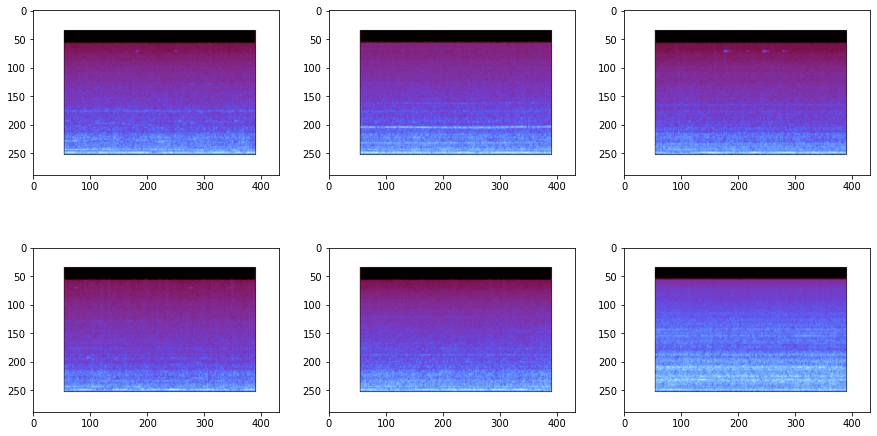

In [29]:
train_normal = './train/Normal'

load_images(train_normal)

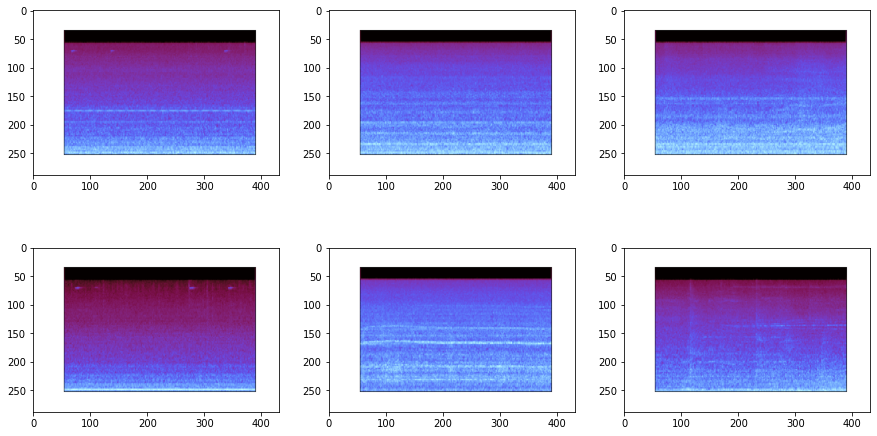

In [30]:
train_abnormal = './train/Abnormal'

load_images(train_abnormal)

### Data Generator

In [7]:
# Image Data Generator for train set

train_gen = ImageDataGenerator(
        validation_split=0.3, 
        rescale=1/255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
)

# Image Data Generator for test set

val_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

In [8]:
train = train_gen.flow_from_directory(
            train_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training'
)

validation = val_gen.flow_from_directory(
            validation_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'validation'
)

test = val_gen.flow_from_directory(
            test_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = False,
)



Found 2858 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Found 177 images belonging to 2 classes.


### Labels

In [9]:
label_map = (train.class_indices)

print(label_map)


{'Abnormal': 0, 'Normal': 1}


### Create Model Function

In [10]:
def create_model():
    
    # Loading VGG16 model with weights after being pre-trained on ImageNet
    model=Sequential()
    model.add(vgg16.VGG16(include_top = False, pooling = 'max', weights = 'imagenet',input_shape = size))
    
    model.add(Dense(2, activation="softmax"))

    
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
    model.summary()
    
    return model

### Save Model - Callbacks

In [11]:
#save the model
checkpoint_path = "Mel_VGG16.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create callbacks with check point
callbacks = [EarlyStopping(monitor='accuracy', patience=2, verbose=1, mode='auto'),
             ModelCheckpoint(checkpoint_path, monitor='accuracy', 
             save_best_only=True, save_weights_only=False, mode='auto')]

 - Verbose: The level of detail about training information output during training

### Fit Model

In [12]:
model = create_model()


2022-03-13 18:30:46.061763: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [13]:
steps_per_epoch= train.samples/train.batch_size

In [16]:
steps_per_epoch

19.8125

In [15]:
steps_per_epoch= validation.samples/train.batch_size

In [17]:
history = model.fit(train, steps_per_epoch= 100, validation_data= validation,
                           epochs= 5, callbacks= callbacks,validation_steps=20)

Epoch 1/5
100/100 [==============================] - 3167s 32s/step - loss: 0.6189 - accuracy: 0.6506 - val_loss: 0.6962 - val_accuracy: 0.5521
Epoch 2/5
100/100 [==============================] - 3396s 34s/step - loss: 0.2018 - accuracy: 0.9169 - val_loss: 0.2963 - val_accuracy: 0.8801
Epoch 3/5
100/100 [==============================] - 2544s 25s/step - loss: 0.1535 - accuracy: 0.9419 - val_loss: 0.1324 - val_accuracy: 0.9685
Epoch 4/5
100/100 [==============================] - 2711s 27s/step - loss: 0.0998 - accuracy: 0.9655 - val_loss: 0.0233 - val_accuracy: 0.9968
Epoch 5/5
100/100 [==============================] - 3208s 32s/step - loss: 0.0852 - accuracy: 0.9669 - val_loss: 0.0350 - val_accuracy: 0.9905


### Classification Report


In [38]:
import pickle
with open('vgg16_History', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

In [52]:
predict = model.predict(test,steps=test.samples)

In [63]:
category = ['Abnormal', 'Normal']

In [69]:
def report(y_true, y_pred,target_names):
    
  print(classification_report(y_true, y_pred, 
                              target_names= target_names))

  con_matrix = confusion_matrix(y_true, y_pred)
    
  sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
  plt.xlabel('Actual Label')
  plt.ylabel('Predicted Label')

              precision    recall  f1-score   support

    Abnormal       0.95      0.99      0.97        84
      Normal       0.99      0.96      0.97        93

    accuracy                           0.97       177
   macro avg       0.97      0.97      0.97       177
weighted avg       0.97      0.97      0.97       177



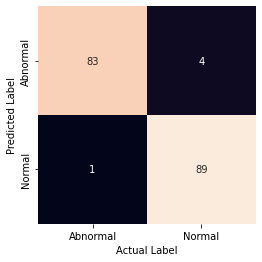

In [70]:
y_pred = np.argmax(predict, axis=1)
classes = ["{:02d}".format(i) for i in range(1, 4)]

report(test.classes,y_pred,category)

### Plot Model

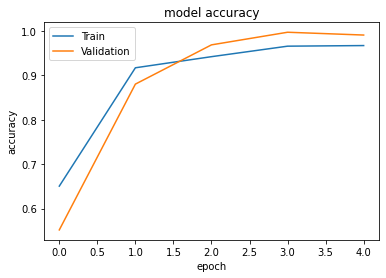

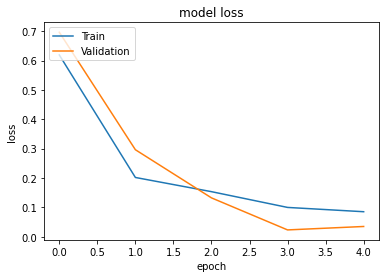

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Prediction

In [74]:
def predict(path):

    img = image.load_img(path, target_size=(432, 288))
    
    # Preprocessing the image
    pp_img = image.img_to_array(img)
    pp_img = pp_img/255
    pp_img = np.expand_dims(pp_img, axis=0)
    
    #Load Model
    saved_model = load_model("Mel_VGG16.h5")

    #predict
    img_pred= saved_model.predict(pp_img)
    
    
    if img_pred[0][0] >= 0.5: 
        pred = ('Abnormal : {:%} percent'.format(img_pred[0][0]))
    
    else: 
        pred = ('Normal : {:%} percent'.format(1- img_pred[0][0]))
        
    plt.title("Anomaly Detection\n"+ pred)  

    plt.imshow(np.squeeze(pp_img))
    
    return  plt.show()

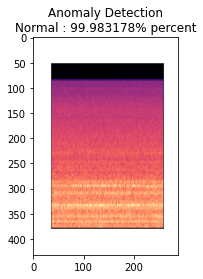

In [76]:
path = 'prediction_images/normal_3000.png'
predict(path)

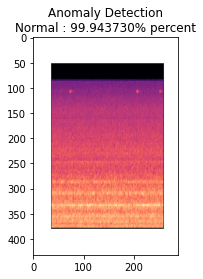

In [77]:
path = 'prediction_images/normal_3013.png'
predict(path)